In [ ]:
#the files
import pandas as pd

base = pd.read_csv('150_gold.csv')
finetuned_t5 = pd.read_csv('150_gold_t5.csv')
pegasus1 = pd.read_csv('150gold-pegasus-1.csv')
pegasus2 = pd.read_csv('150gold-pegasus-1.csv')
filtered_pegasus = pd.read_csv('150gold_filtered-pegasus.csv')
filtered_t5 = pd.read_csv('150gold_filtered-t5.csv')
base_t5 = pd.read_csv('t5_base_inference.csv')
extractive = pd.read_csv('extractive_models.csv')
ensemble = pd.read_csv('ensemble_models.csv')

In [ ]:
base.head(2)

,episode_id,episode_name,episode_description,transcript,textrank_summary,lexrank_summary,lsa_summary,semi_supervised,supervised,extractive,t5_abstractive,first_five
0,spotify:episode:08hXUWN6aOnHULXrqMiwTi,Recruiting Secrets From a MLM Recruiting Monst...,If you want to start mastering recruiting whic...,Hello everybody. What's going on in this Jess...,Let's download these stories about whoever I d...,You can do whatever networking events and I'm ...,We're going to talk about some powerful recrui...,"You cannot scummy hashtag wisely, or the peop...",In this episode I talk about some powerful re...,"You cannot scummy hashtag wisely, or the peopl...",--- This episode is sponsored by Anchor: The ...,Hello everybody. What's going on in this Jess...
1,spotify:episode:0CExTNH4LFqp1ec1mhTd4I,A Public Service Announcement from the mrbrown...,Don't be a silent victim of crime. a parody fr...,"Ladies, have you been molested don't be a vic...",Have someone escort you home when it's late ab...,But you can touch his life. But you can touch ...,If you only touched you in minor ways never mi...,If you have been molested call the police sho...,"If you have been molested, here are some of t...","Ladies, have you been molested don't be a vict...","Ladies, have you been molested? Don't be a sil...","Ladies, have you been molested don't be a vic..."


In [ ]:
#clean the episode descriptions
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import string

def clean_up(text):
    head, _ , _ = text.partition(' ---')
    head = head.strip()
    if len(head) > 0:
        first_letter = head[0].capitalize()
        head = first_letter + head[1:]
        if head[-1] in string.punctuation:
            head += '.'
    return head

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#keyword extraction class
from collections import OrderedDict
import numpy as np
import spacy
!python -m spacy download en_core_web_sm
!python -m spacy link en_core_web_sm en
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en')

class TextRank4Keyword():
    """Extract keywords from text"""
    
    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 10 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    # def normalize(self, token):
    #     if (token.is_alpha):
    #         return token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False and token.is_alpha:
                    # token = self.normalize(token)
                    # selected_words.append(token)
                    if lower is True:
                        selected_words.append(token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_)
                    else:
                        selected_words.append(token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_)
            sentences.append(selected_words)
        return sentences
    
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=100000, limit=0.0):
        """Print top number keywords"""
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        keywords = []
        for i, (key, value) in enumerate(node_weight.items()):
            if value >= limit:
                keywords.append(key)
            # print(key + ' - ' + str(value))
            # if i > number:
            #     break
        return keywords
        
        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')

✘ Link 'en' already exists
To overwrite an existing link, use the --force flag



In [ ]:
#get scores
def scores(transcript_keywords, summary_keywords):
    total_keywords = len(transcript_keywords)
    total_summary_keywords = len(summary_keywords)
#     print(total_keywords, total_summary_keywords)
    correct_keywords = 0

    for keyword in summary_keywords:
        if keyword in transcript_keywords:
            correct_keywords += 1

    
    precision = 0
    recall = 0
    f1 = 0
    if total_keywords == 0:
        return {'precision':precision, 'recall':recall, 'f1':f1}
    
    if total_summary_keywords > 0:
        precision = correct_keywords / total_summary_keywords
        recall = correct_keywords / total_keywords
    
    if precision > 0 and recall > 0:
        f1 = (2 *(recall * precision)) / (recall + precision)
    
    return {'precision':precision, 'recall':recall, 'f1':f1}

In [ ]:
tr4w = TextRank4Keyword()
def compute_scores(transcript, summary):
    tr4w.analyze(transcript, candidate_pos = ['NOUN','PROPN'], window_size=4, lower=True)
    transcript_keywords = tr4w.get_keywords()
    tr4w.analyze(summary, candidate_pos = ['NOUN','PROPN'], window_size=4, lower=True)
    summary_keywords = tr4w.get_keywords()
    return scores(transcript_keywords, summary_keywords)

In [ ]:
base['episode_description'] = base.apply(lambda row: clean_up(row['episode_description']), axis=1)
base['scores'] =  base.apply(lambda row: compute_scores(row['transcript'] ,row['episode_description']), axis=1)

In [ ]:
def get_precision(scores):
    precision = scores['precision']
    return precision

def get_recall(scores):
    recall = scores['recall']
    return recall

def get_f1(scores):
    f1 = scores['f1']
    return f1

In [ ]:
base['precision'] = base.apply(lambda row: get_precision(row['scores']), axis=1)
base['recall'] = base.apply(lambda row: get_recall(row['scores']), axis=1)
base['f1'] = base.apply(lambda row: get_f1(row['scores']), axis=1)

In [ ]:
base.head(2)

,episode_id,episode_name,episode_description,transcript,textrank_summary,lexrank_summary,lsa_summary,semi_supervised,supervised,extractive,t5_abstractive,first_five,scores,precision,recall,f1
0,spotify:episode:08hXUWN6aOnHULXrqMiwTi,Recruiting Secrets From a MLM Recruiting Monst...,If you want to start mastering recruiting whic...,Hello everybody. What's going on in this Jess...,Let's download these stories about whoever I d...,You can do whatever networking events and I'm ...,We're going to talk about some powerful recrui...,"You cannot scummy hashtag wisely, or the peop...",In this episode I talk about some powerful re...,"You cannot scummy hashtag wisely, or the peopl...",--- This episode is sponsored by Anchor: The ...,Hello everybody. What's going on in this Jess...,"{'precision': 0.7857142857142857, 'recall': 0....",0.785714,0.036913,0.070513
1,spotify:episode:0CExTNH4LFqp1ec1mhTd4I,A Public Service Announcement from the mrbrown...,Don't be a silent victim of crime. a parody fr...,"Ladies, have you been molested don't be a vic...",Have someone escort you home when it's late ab...,But you can touch his life. But you can touch ...,If you only touched you in minor ways never mi...,If you have been molested call the police sho...,"If you have been molested, here are some of t...","Ladies, have you been molested don't be a vict...","Ladies, have you been molested? Don't be a sil...","Ladies, have you been molested don't be a vic...","{'precision': 1.0, 'recall': 0.096774193548387...",1.000000,0.096774,0.176471


In [ ]:
filtered = base[(base['precision'] >= 0.75)]
filtered.reset_index(inplace=True, drop=True)
len(filtered)

54

In [ ]:
filtered.head(1)

,episode_id,episode_name,episode_description,transcript,textrank_summary,lexrank_summary,lsa_summary,semi_supervised,supervised,extractive,t5_abstractive,first_five,scores,precision,recall,f1
0,spotify:episode:08hXUWN6aOnHULXrqMiwTi,Recruiting Secrets From a MLM Recruiting Monst...,If you want to start mastering recruiting whic...,Hello everybody. What's going on in this Jess...,Let's download these stories about whoever I d...,You can do whatever networking events and I'm ...,We're going to talk about some powerful recrui...,"You cannot scummy hashtag wisely, or the peop...",In this episode I talk about some powerful re...,"You cannot scummy hashtag wisely, or the peopl...",--- This episode is sponsored by Anchor: The ...,Hello everybody. What's going on in this Jess...,"{'precision': 0.7857142857142857, 'recall': 0....",0.785714,0.036913,0.070513


In [ ]:
filtered.iloc[4]['supervised']

' In this episode I talk about some of the key learnings that I got when I took a social media Hiatus for four months.   ---   Send in a voice message: https://anchor.fm/bevinfm/message'

In [ ]:
!pip install rouge
from rouge import Rouge
rouge = Rouge()

In [ ]:
 #filtered['supervised'] = filtered.apply(lambda row: clean_up(row['supervised']), axis=1)
#  rouge.get_scores(filtered['supervised'], filtered['episode_description'],  avg=True)

# len(pegasus2)

150

In [ ]:
ensemble.head(1)

,Unnamed: 0,episode_id,transcript,episode_description,spanBert_t5,firstN_t5
0,0,spotify:episode:08hXUWN6aOnHULXrqMiwTi,Hello everybody. What's going on in this Jess...,If you want to start mastering recruiting whic...,This is the #1 network marketing podcast in th...,This is a great podcast to start your network ...


In [ ]:
filtered_abs = filtered.merge(ensemble, how='inner', on='episode_id')
# filtered_abs = filtered_abs.merge(pegasus2, how='inner', on='episode_id')
# filtered_abs = filtered_abs.merge(filtered_pegasus, how='inner', on='episode_id')
# filtered_abs.head(2)

In [ ]:
filtered_abs.head(2)

,episode_id,episode_name,episode_description_x,transcript_x,textrank_summary,lexrank_summary,lsa_summary,semi_supervised,supervised,extractive,t5_abstractive,first_five,scores,precision,recall,f1,Unnamed: 0,transcript_y,episode_description_y,spanBert_t5,firstN_t5
0,spotify:episode:08hXUWN6aOnHULXrqMiwTi,Recruiting Secrets From a MLM Recruiting Monst...,If you want to start mastering recruiting whic...,Hello everybody. What's going on in this Jess...,Let's download these stories about whoever I d...,You can do whatever networking events and I'm ...,We're going to talk about some powerful recrui...,"You cannot scummy hashtag wisely, or the peop...",In this episode I talk about some powerful re...,"You cannot scummy hashtag wisely, or the peopl...",--- This episode is sponsored by Anchor: The ...,Hello everybody. What's going on in this Jess...,"{'precision': 0.7857142857142857, 'recall': 0....",0.785714,0.036913,0.070513,0,Hello everybody. What's going on in this Jess...,If you want to start mastering recruiting whic...,This is the #1 network marketing podcast in th...,This is a great podcast to start your network ...
1,spotify:episode:0CExTNH4LFqp1ec1mhTd4I,A Public Service Announcement from the mrbrown...,Don't be a silent victim of crime. a parody fr...,"Ladies, have you been molested don't be a vic...",Have someone escort you home when it's late ab...,But you can touch his life. But you can touch ...,If you only touched you in minor ways never mi...,If you have been molested call the police sho...,"If you have been molested, here are some of t...","Ladies, have you been molested don't be a vict...","Ladies, have you been molested? Don't be a sil...","Ladies, have you been molested don't be a vic...","{'precision': 1.0, 'recall': 0.096774193548387...",1.000000,0.096774,0.176471,1,"Ladies, have you been molested don't be a vic...",Don't be a silent victim of crime. a parody fr...,--- Send in a voice message: https://anchor.fm...,This is a Public Service Announcement for Mr. ...


In [ ]:
# filtered_abs = filtered_abs.loc[:,~filtered_abs.columns.duplicated()]

In [ ]:
# filtered_abs.head(1)

,episode_id,episode_name_x,episode_description_x,transcript_x,textrank_summary_x,lexrank_summary_x,lsa_summary_x,semi_supervised_x,supervised_x,extractive_x,t5_abstractive_x,first_five_x,scores,precision,recall,f1,episode_name_y,episode_description_y,transcript_y,textrank_summary_y,lexrank_summary_y,lsa_summary_y,semi_supervised_y,supervised_y,extractive_y,t5_abstractive_y,first_five_y,pegasus-trained_x,pegasus-trained_y,filtered-t5
0,spotify:episode:08hXUWN6aOnHULXrqMiwTi,Recruiting Secrets From a MLM Recruiting Monst...,If you want to start mastering recruiting whic...,Hello everybody. What's going on in this Jess...,Let's download these stories about whoever I d...,You can do whatever networking events and I'm ...,We're going to talk about some powerful recrui...,"You cannot scummy hashtag wisely, or the peop...",In this episode I talk about some powerful re...,"You cannot scummy hashtag wisely, or the peopl...",--- This episode is sponsored by Anchor: The ...,Hello everybody. What's going on in this Jess...,"{'precision': 0.7857142857142857, 'recall': 0....",0.785714,0.036913,0.070513,Recruiting Secrets From a MLM Recruiting Monst...,If you want to start mastering recruiting whic...,Hello everybody. What's going on in this Jess...,Let's download these stories about whoever I d...,You can do whatever networking events and I'm ...,We're going to talk about some powerful recrui...,"You cannot scummy hashtag wisely, or the peop...",In this episode I talk about some powerful re...,"You cannot scummy hashtag wisely, or the peopl...",--- This episode is sponsored by Anchor: The ...,Hello everybody. What's going on in this Jess...,Is a powerful recruiting technique for massive...,Is a powerful recruiting technique for massive...,Jesse Lee is the Godfather of network marketin...


In [ ]:
# filtered_abs = filtered_abs[['episode_id', 'episode_name_x', 'episode_description_x', 'pegasus-trained_x', 'pegasus-trained_y', 'filtered-t5']]
filtered_abs['spanBert_t5'] = filtered_abs.apply(lambda row: clean_up(row['spanBert_t5']), axis=1)
filtered_abs['firstN_t5'] = filtered_abs.apply(lambda row: clean_up(row['firstN_t5']), axis=1)
# filtered_abs['filtered_pegasus'] = filtered_abs.apply(lambda row: clean_up(row['filtered-t5']), axis=1)

In [ ]:
# len(filtered_abs)

54

In [ ]:
rouge.get_scores(filtered_abs['firstN_t5'], filtered_abs['episode_description_x'],  avg=True)

{'rouge-1': {'f': 0.15267601255025376,
  'p': 0.19362990629251883,
  'r': 0.20668914315203887},
 'rouge-2': {'f': 0.03538914789773092,
  'p': 0.04007405098673013,
  'r': 0.054443292152407625},
 'rouge-l': {'f': 0.14380397639876452,
  'p': 0.17304373223203856,
  'r': 0.1905634875397711}}

In [ ]:
def get_rouge(summary, gold):
  s = str(summary)
  g = str(gold)
  res = rouge.get_scores(s, g)
  return res[0]['rouge-l']['f'] * 100


In [ ]:
filtered_abs.head(1)

,episode_id,episode_name,episode_description_x,transcript_x,textrank_summary,lexrank_summary,lsa_summary,semi_supervised,supervised,extractive,t5_abstractive,first_five,scores,precision,recall,f1,Unnamed: 0,transcript_y,episode_description_y,spanBert_t5,firstN_t5
0,spotify:episode:08hXUWN6aOnHULXrqMiwTi,Recruiting Secrets From a MLM Recruiting Monst...,If you want to start mastering recruiting whic...,Hello everybody. What's going on in this Jess...,Let's download these stories about whoever I d...,You can do whatever networking events and I'm ...,We're going to talk about some powerful recrui...,"You cannot scummy hashtag wisely, or the peop...",In this episode I talk about some powerful re...,"You cannot scummy hashtag wisely, or the peopl...",--- This episode is sponsored by Anchor: The ...,Hello everybody. What's going on in this Jess...,"{'precision': 0.7857142857142857, 'recall': 0....",0.785714,0.036913,0.070513,0,Hello everybody. What's going on in this Jess...,If you want to start mastering recruiting whic...,This is the #1 network marketing podcast in th...,This is a great podcast to start your network ...


In [ ]:
filtered_abs['SpanBERT + T5 ROUGE-L'] = filtered_abs.apply(lambda row: get_rouge(row['spanBert_t5'], row['episode_description_x']), axis=1)
filtered_abs['First 15 + T5 ROUGE-L'] = filtered_abs.apply(lambda row: get_rouge(row['firstN_t5'], row['episode_description_x']), axis=1)
# filtered_abs['T5 Finetuned ROUGE-L'] = filtered_abs.apply(lambda row: get_rouge(row['t5_abstractive'], row['episode_description_x']), axis=1)

In [ ]:
# filtered_abs.head(1)

,episode_id,episode_name_x,episode_description_x,t5_base,filtered-t5,t5_abstractive,T5 Base ROUGE-L,T5 Filtered ROUGE-L,T5 Finetuned ROUGE-L
0,spotify:episode:08hXUWN6aOnHULXrqMiwTi,Recruiting Secrets From a MLM Recruiting Monst...,If you want to start mastering recruiting whic...,If you want to be a network marketing recruiti...,.. make up your mind and start recruiting!.. i...,This is a great episode to start your network ...,32.183908,21.238938,19.178082


Text(0.5, 1.0, 'Boxplot of ROUGE-L Scores of Ensemble Models')

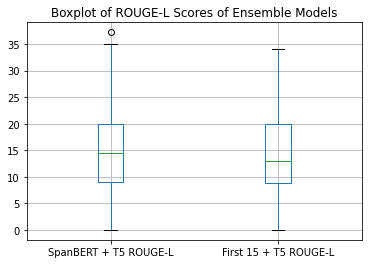

In [ ]:
import matplotlib.pyplot as plt
filtered_abs.boxplot(column=['SpanBERT + T5 ROUGE-L', 'First 15 + T5 ROUGE-L'])
plt.suptitle("")
plt.title("Boxplot of ROUGE-L Scores of Ensemble Models")

In [ ]:
# filtered_abs['T5 Finetuned ROUGE-L'].max()

41.37930989298454

In [ ]:
# filtered_abs[filtered_abs['T5 Finetuned ROUGE-L'] == 0]

,episode_id,episode_name_x,episode_description_x,t5_base,filtered-t5,t5_abstractive,T5 Base ROUGE-L,T5 Filtered ROUGE-L,T5 Finetuned ROUGE-L
3,spotify:episode:0DKARHBAz6GNwwIBz9Y4Sk,Fear? I Don't Know Her!,"Hey eaters!! To commemorate spooky season, thi...",A lot of people are afraid of what they're doi...,". We talk about how we can overcome fear, and ...",This episode we talk about fear and how it can...,7.692307,3.703703,0.0
31,spotify:episode:4oTmr0q3EuTvaehhsY6lcu,21 Signs Shes No Good,Just Listen G,"A lot of women aren't good at what they do, bu...",".. if you’re single, it’s time to take care of...",This is a list of the 21 signs to avoid in you...,0.000000,0.000000,0.0


In [ ]:
# filtered_abs.iloc[13]['t5_abstractive']

'This episode is all about how to start your own portfolio..'

In [ ]:
ensemble.iloc[120]['firstN_t5']

"Today's episode we will continue our fourth part of week 2 with 4 new words!"

In [ ]:
pegasus1.iloc[120]['pegasus-trained']

'Is incomprehensible, and we are going to continue our fourth part of week two vocabulary.'

In [ ]:
# filtered_t5.iloc[120]['filtered-t5']

'. Incomprehensible, Manipulate, Maximize and Mimic. These words will help you understand the 4 new words for today: Incomprehensible, Manipulate, Maximize, Mimic, Maximum, & Mimic.. Enjoy!...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................